In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import FinanceDataReader as fdr
from sklearn import neighbors,svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import FinanceDataReader as fdr
import mglearn
from sklearn.preprocessing import MinMaxScaler
import sklearn

#성과 평가
from sklearn.metrics import confusion_matrix #오차행렬
from sklearn.metrics import accuracy_score #정확도
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

setlen=2000


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_10=df["Close"].rolling(10).mean()
    MA_60=df["Close"].rolling(60).mean()
    df=df.assign(MA_10=MA_10,MA_60=MA_60).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df
   
    #시간
def get_time(df):
    time=np.linspace(0,10,len(df),endpoint=False).reshape(-1,1)
    df=df.assign(time=time)
    
    return df

In [9]:


KS=fdr.DataReader("KS11","2009-01-01","2019-08-14")

#특성 추가---
KS=get_MA(KS)
KS=get_stochastic(KS)
KS=get_time(KS)

X=KS
#--------

# 분위수로 조정한 5중 분류  ---------------
df = pd.DataFrame(index = KS.index, columns = ['Y'])

initial = -1
num = 0
for i in np.linspace(50,100,2):
    df.loc[KS [KS['Change'] >= initial] [KS['Change'] <= round(np.percentile(KS['Change'], i),4)].index] = num
    initial = round(np.percentile(KS['Change'], i),4)
    num += 1
y=df
y=y.astype('int')
#-----------------------------------------


#미래 예측을 위한 시간조정 ------------------- 
y=pd.DataFrame(np.array(y),index=KS.index).shift(-1).dropna()
X=X.loc[y.index]
#----------------------------

setlen=2000
X_train,X_test,y_train,y_test=X[:setlen],X[setlen:],y[:setlen],y[setlen:]

reg=neighbors.KNeighborsClassifier(n_neighbors=4).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
confusion

훈련 세트 정확도:0.680
테스트 세트 정확도:0.482


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([[188,  95],
       [199,  86]], dtype=int64)

In [4]:

reg=LogisticRegression().fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
confusion

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


훈련 세트 정확도:0.215
테스트 세트 정확도:0.160


array([[  0,   0,   0,   0, 100],
       [  0,   0,   0,   0, 123],
       [  0,   0,   0,   0, 122],
       [  0,   0,   0,   0, 132],
       [  0,   0,   0,   0,  91]], dtype=int64)

In [5]:

reg=GradientBoostingClassifier().fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
confusion

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도:0.706
테스트 세트 정확도:0.220


array([[ 5, 59,  6, 14, 16],
       [12, 82,  6,  9, 14],
       [12, 76,  8, 22,  4],
       [13, 78,  7, 21, 13],
       [ 9, 47, 15, 11,  9]], dtype=int64)

In [6]:

reg=RandomForestClassifier().fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

confusion=confusion_matrix(y_test,reg.predict(X_test))
confusion

훈련 세트 정확도:0.985
테스트 세트 정확도:0.171


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


array([[ 74,  13,   7,   5,   1],
       [ 99,   5,   8,   6,   5],
       [ 94,  14,   9,   5,   0],
       [103,   8,  10,   5,   6],
       [ 62,   8,  12,   5,   4]], dtype=int64)

In [ ]:
print("이중 분류")
print(classification_report(y_test,reg4,target_names=["하락(0)","상승(1)"]))

In [10]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y w

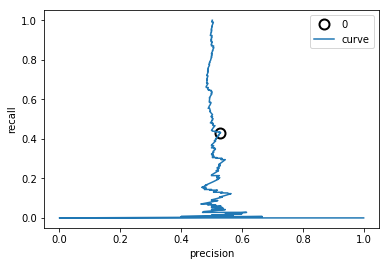

In [11]:

reg1=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
reg2=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
reg3=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
reg4=GradientBoostingClassifier(random_state=0).fit(X_train,y_train)

precision,recall,thresholds=precision_recall_curve(y_test,reg4.decision_function(X_test))

close_zero=np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero],recall[close_zero],'o',markersize=10,label='0',fillstyle="none",c='k',mew=2)
plt.plot(precision,recall,label="curve")
plt.xlabel("precision")
plt.ylabel('recall')
plt.legend(loc="best")


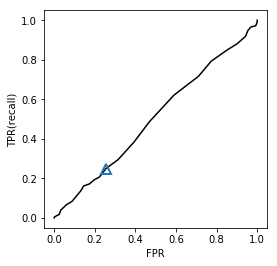

In [14]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(4, 4))
fpr_rf,tpr_rf,thresholds_rf=roc_curve(y_test,reg3.predict_proba(X_test)[:,1])

plt.plot(fpr_rf,tpr_rf,'k')
plt.xlabel("FPR")
plt.ylabel("TPR(recall)")
plt.plot(fpr_rf[close_default_rf],tpr_rf[close_default_rf],'^',markersize=10,label="RF recall : 0.5",fillstyle="none",mew=2)
